# ViT

paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf)

## setup

In [76]:
import numpy as np
import math
from tqdm.notebook import tqdm
import einops
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from enum import Enum, auto
from collections import defaultdict
from IPython.display import HTML
from sklearn.decomposition import PCA
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## data

In [64]:
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=True),
    batch_size=128,
    shuffle=True)

data_test = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=False),
    batch_size=128,
    shuffle=True)

## helpers

In [65]:
@torch.no_grad()
def accuracy(model, label='test', silent=False):
    model.eval()
    dataset = data_test if label == 'test' else data
    correct = 0
    for x, y in dataset:
        x, y = x.to(device), y.to(device)
        res = model(x).argmax(-1)
        correct += (res == y).float().sum()
    acc = correct / len(dataset)
    if not silent: print(f'accuracy on {label:5}: {acc}')
    return acc

In [66]:
def plot(*args, n_col=None, figsize=None, block_size=3):
    '''Plot images in a grid
    usage: plot(img1, img2, ...)
    optional: n_col=3, figsize=(12, 8), block_size=1

    img: torch.Tensor of shape (H, W) or (C, H, W) or [(H, W), ...] or [(C, H, W), ...]
    '''
    imgs = []
    for img in args:
        if isinstance(img, torch.Tensor):
            if img.dim() == 4: imgs.extend([img[i] for i in range(img.shape[0])])
            else: imgs.append(img)

    # flatten channels
    imgs = [img.squeeze(0) if img.dim() == 3 else img for img in imgs]
    imgs = [img.detach().cpu() for img in imgs]

    if n_col is None: n_col = len(imgs)
    n_row = math.ceil(len(imgs) / n_col)
    if figsize is None: figsize = (n_col * block_size, n_row * block_size)
    # normalize ax to 2d array
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1: ax = np.array([[ax]])
    elif n_row == 1: ax = ax.reshape((1, -1))
    elif n_col == 1: ax = ax.reshape((-1, 1))
    # plot
    for i, img in enumerate(imgs):
        idx = (i // n_col, i % n_col)
        ax[idx].imshow(img)
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i // n_col, i % n_col)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        if i >= len(imgs): ax[idx].axis('off')
    plt.tight_layout()
    plt.show()

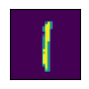

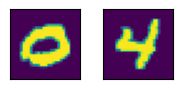

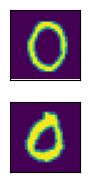

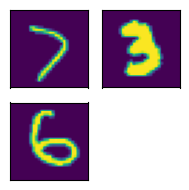

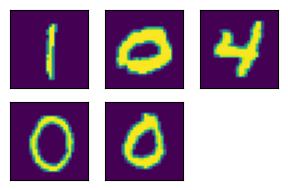

In [67]:
# test plot function
def test_plot(scale=1):
    imgs = next(iter(data))[0]
    plot(imgs[0], block_size=scale)
    plot(imgs[1], imgs[2], block_size=scale)
    plot(imgs[3], imgs[4], n_col=scale, block_size=scale)
    plot(imgs[5], imgs[6], imgs[7], n_col=2, block_size=scale)
    plot(imgs[:5], n_col=3, block_size=scale)

test_plot()

In [68]:
next(iter(data))[0].shape

torch.Size([128, 1, 28, 28])

## encoder

In [69]:
N_HEADS = 1
N_BLOCKS = 2
EMBED_SIZE = 16
# EMBED_SIZE = 20
VOCAB_SIZE = 10
HIDDEN_SIZE = 32
IMG_SIZE = 28
CHUNK_SIZE = 7
assert IMG_SIZE % CHUNK_SIZE == 0
CONTEXT_SIZE = 1 + IMG_SIZE // CHUNK_SIZE
LEARNING_RATE = 3e-4
DROPOUT = 0.1

In [70]:
def get_sinusoidal_positional_encoding(context_size=CONTEXT_SIZE, embed_size=EMBED_SIZE):
  position = torch.arange(context_size).unsqueeze(1)
  div_term = torch.exp(torch.arange(0, embed_size, 2) * -(math.log(10000.0) / embed_size))
  positional_encoding = torch.zeros(context_size, embed_size)
  positional_encoding[:, 0::2] = torch.sin(position * div_term)
  positional_encoding[:, 1::2] = torch.cos(position * div_term)
  return positional_encoding.to(device)

In [71]:
activations = {}

class Positional(Enum):
  NONE = auto()
  SINUSOIDAL = auto()
  LEARNED = auto()

class MultiheadAttention(nn.Module):
  def __init__(self, n_heads, embed_size, positional, dropout, n_block=0):
    super().__init__()
    assert embed_size % n_heads == 0, f'{embed_size=} should be divisible by {n_heads=}'
    self.n_heads = n_heads
    self.embed_size = embed_size
    self.positional = positional
    self.dropout_rate = dropout
    self.n_block = n_block
    self.qkv = nn.Linear(embed_size, embed_size * 3, bias=False) # generate Q, K, V all at once
    self.dropout = nn.Dropout(dropout)
    self.ln = nn.LayerNorm(embed_size)

  def forward(self, x):
    B, C, E = x.shape
    # pre-layernorm
    x = self.ln(x)
    q, k, v = self.qkv(x).chunk(3, dim=-1)
    # split heads
    q = q.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    k = k.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    v = v.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    # by hand
    correlation = q @ k.transpose(-2, -1)
    correlation = correlation / math.sqrt(k.shape[-1])
    correlation = F.softmax(correlation, dim=-1)
    activations[self.n_block] = correlation.detach()
    correlation = F.dropout(correlation, p=self.dropout_rate, training=self.training)
    y = correlation @ v
    # combine heads
    y = y.transpose(1, 2).contiguous().view(B, C, self.embed_size)
    y = self.dropout(y)
    return y

class Block(nn.Module):
  def __init__(self, positional, n_heads, embed_size, hidden_size, dropout, n_block):
    super().__init__()
    self.block = n_block
    self.attention = MultiheadAttention(n_heads, embed_size, positional=positional, dropout=dropout, n_block=n_block)
    self.ff = nn.Sequential(
      nn.LayerNorm(embed_size), # pre-layernorm
      nn.Linear(embed_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, embed_size),
      nn.Dropout(dropout)
    )

  def forward(self, x):
    x = x + self.attention(x)
    x = x + self.ff(x)
    return x

class Net(nn.Module):
  def __init__(self, positional=Positional.LEARNED, n_heads=N_HEADS, n_blocks=N_BLOCKS, embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE, context_size=CONTEXT_SIZE, dropout=DROPOUT):
    super().__init__()
    self.positional = positional
    self.context_size = context_size
    # net
    if positional == Positional.SINUSOIDAL: self.positional_embedding = get_sinusoidal_positional_encoding()
    elif positional == Positional.LEARNED: self.positional_embedding = nn.Embedding(context_size, embed_size)      
    else: self.positional_embedding = torch.tensor(0.).to(device)
    self.token_embedding = nn.Embedding(vocab_size, embed_size)
    self.blocks = nn.Sequential(*[Block(positional, n_heads, embed_size, hidden_size, dropout, i) for i in range(n_blocks)])
    self.head = nn.Linear(embed_size, vocab_size)

  def forward(self, x):
    # ============ FIX THE CODE HERE ============
    b, c, h, w = x.shape
    x = x.view(b, -1, 16)
    # ============        END        ============

    # (batch_size, context_size)
    # x = self.token_embedding(x) # TODO: CHANGE INTO IMAGE CHUNKING
    # # positional encoding
    # x = x + self.get_positional_embedding()

    # attention and ff
    x = self.blocks(x)
    # head
    x = self.head(x)

    # only look at first token:
    x = x[:, 0, :]

    return x
  
  def get_positional_embedding(self):
    if self.positional == Positional.LEARNED:
      return self.positional_embedding(torch.arange(0, self.context_size).to(device))
    return self.positional_embedding
    
  def get_positional_embeddings(self):
    return self.get_positional_embedding().detach().cpu()

## train

In [72]:
model = Net(positional=Positional.LEARNED, n_heads=1, n_blocks=2).to(device)
positional_embeddings = []

In [79]:
def train(model, epochs, lr=LEARNING_RATE, do_log=True, log_every=1):
  model.train()
  opt = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in tqdm(range(epochs)):
    for X, Y in data:
      X, Y = X.to(device), Y.to(device)
      out = model(X)
      loss = F.cross_entropy(out, Y)
      opt.zero_grad()
      loss.backward()
      opt.step()
    if do_log and epoch % log_every == 0:
      print(f'{epoch:5} {loss.item()}')

train(model, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

    0 1.6164523363113403
    1 1.3576984405517578
    2 1.58782160282135
    3 1.4169913530349731
    4 1.4555071592330933


In [80]:
_ = accuracy(model)
_ = accuracy(model, label='train')

accuracy on test : 68.79747009277344
accuracy on train: 68.81876373291016


## visualize attention

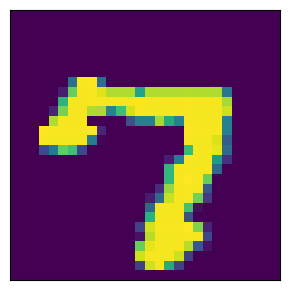

0


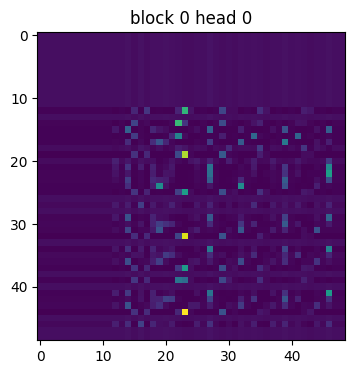

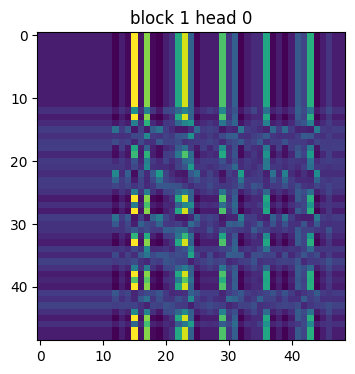

In [92]:
@torch.no_grad()
def visualize_attention(model, img):
    model.eval()
    plot(img)
    img = img.to(device).unsqueeze(0)
    out = model(img).argmax(-1).item()
    print(out)

    for block, acts in activations.items():
        if acts.dim() == 4:
            acts = acts.squeeze(0)
        repeat = acts.shape[0]
        fig, ax = plt.subplots(1, repeat, figsize=(12, 4))
        if repeat == 1: ax = np.array([ax])
        for i in range(repeat):
            ax[i].imshow(acts[i].cpu())
            ax[i].set_title(f'block {block} head {i}')

visualize_attention(model, next(iter(data))[0][0])